<h1> Part 1: Introduction </h1>

<div> The goal of this lab is threefold:
    <ul>
        <li> To review basic concepts of neural network training (establish a common vocabulary for the class)</li>
        <li> Illustrate the basic principles involved in training of a neural network. </li>
        <li> Create a foundation for the next labs in this class that will eventually lead us to a multi GPU implementation of a neural network.</li>
    </ul>
</div>
<br/>
<div>As discussed in the lecture in this exercise we will start (part one of this lab) with the simplest possible neural network, a single linear neuron: <img src="https://developer.download.nvidia.com/training/images/C-MG-01-V1_task1_img_LinearNeuron.png" width="150" height="150"/> 
We will illustrate how this neural network can be trained using Gradient Descent and Stochastic Gradient Descent algorithms. 
    
<br/><br/>
In the next part of this lab (part two) we will build on top of this code extending it to an implementation of a simple multilayered neural network (multilayered perceptron):
   <img src="https://developer.download.nvidia.com/training/images/C-MG-01-V1_task1_img_MultiLayerPerceptron.png" width="150" height="150"/> 
Finally (part three) we will further expand our code to build its multi-GPU implementation:
<img src="https://developer.download.nvidia.com/training/images/C-MG-01-V1_task1_img_MultiGPU.png" width="250" height="250"/> 
</div>

<div>Upon completion of the Lab 1 (all three parts) you will gain a detailed understanding on the theory involved in training a neural network across a single as well as multiple GPUs. We will use this knowledge in Lecture 2 and Lab 2 to illustrate all of the practical challenges involved in large scale distributed training and finally in Lab 3 we will review a state of the art implementation of a distributed training of a modern Deep Neural Network.</div>

<h1> Training a neural network. </h1>

<h2> Generating a random dataset. </h2>
<div>In this exercise we will train our neural network to fit a randomly generated dataset. Since our neural network is simple it does not have much predictive power. As a consequence we should generate a simplistic dataset. In this exercise we will generate a dataset following a straight line and add a level of gaussian noise to make the problem more realistic. </div><br/>
<div> We start by importing the necessary python libraries. Since this exercise is deliberately simple the list is quite short:</div>

In [1]:
# Numpy is a fundamental package for scientific computing. It contains, among many, an implementation of an array
# that we will use in this exercise.
import numpy as np
# We will be generating our own RANDOM dataset. As a consequence we need functionality to generate random numbers.
import random
# We will be plotting the progress of training as well as the behaviour of our training algorithm
# hence MatPlotLib. A python package that can be used to generate 2D and 3D plots.
import matplotlib.pyplot as plt
# TensorFlow - so the deep learning framework of choice for this class.
import tensorflow as tf

<div>The variables listed below define the properties of this generated dataset. Let’s start with the values listed below (feel free to change them at a later stage to observe the impact the noise will have on algorithm performance and algorithm stability). </div>

In [3]:
# Define the number of samples/data points you want to generate
n_samples = 100
# We will define a dataset that lies on a line as defined by y = a_gen * x + b_gen
a_gen = 10
b_gen = 2
# To make the problem a bit more interesting we will add some gaussian noise as defined by the mean and standard deviation
# defined below.
mean_gen = 0
std_gen = 0.5

In [4]:
# This section generates the training dataset as defined by the variables in the section above.
data = [(x,a_gen*(x+np.random.normal(loc=mean_gen, scale=std_gen, size=None)) + b_gen)
         for x in np.random.uniform(0,10,n_samples)]
data = np.array(data, dtype=[('x',float),('y',float)])

In [17]:
data[0]

(6.01550963, 62.66323198)

In [15]:
data.shape

(100,)

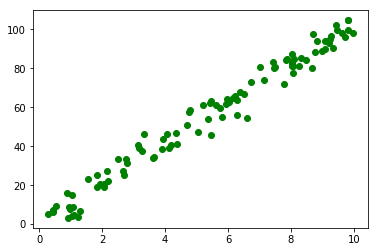

In [5]:
# This section plots our randomly generated dataset
plt.plot(data['x'],data['y'], 'go')
plt.show()

<h2> Defining the model. </h2>

<div>Regardless of the complexity of the machine learning problem the process of code development is identical and consists of:
<ul>
        <li> Creating a definition of the model</li>
        <li> Defining the cost function that will guide our training process. The cost function effectively is a definition of success that informs our optimization algorithm about the progress made during training. </li>
        <li> Then iteratively:
            <ul>
                <li>Calculating the gradient of the cost function with respect to the model weights.</li>
                <li>Updating the model weights to minimize the cost function.</li>
            </ul>
        </li>
    </ul>
 
Lets implement the above for our simple model. We start by defining the model:
<img src="https://developer.download.nvidia.com/training/images/C-MG-01-V1_task1_img_LinearNeuron.png" width="150" height="150"/>
</div>

In [6]:
with tf.device('/device:GPU:0'):
    # Create the placeholders for the data to be used in TensorFlow
    X = tf.placeholder(tf.float32, name="X")
    Y = tf.placeholder(tf.float32, name="Y")
    
    # Create our model variables a (indicated here as w what stands for weights) and b (referred to as bias).
    w = tf.Variable(0.0, name="weights")
    b = tf.Variable(0.0, name="bias")
    
    # Define out model. We are implementing a simple linear neuron as per the diagram listed above. 
    Y_predicted = X * w + b

<h2> Defining the loss function</h2>
<div> We now must define what do we mean by success. There exists a wide range of measures of success (so cost functions) that can be used by neural networks. For more details on the range of cost function you can use and a detailed explanation of how to make this choice refer to section 6.2.1 of the <a href="http://www.deeplearningbook.org/">Deep Learning Book</a> by Ian Goodfellow and Yoshua Bengio and Aaron Courville.</div>
<br/> 
<div>In our case we will use a simple definition of success. We will measure the total <b>squared distance</b> of all of the points in the dataset from the straight line we are trying to find. <img src="https://developer.download.nvidia.com/training/images/C-MG-01-V1_task1_img_CostFunction.png" width="250" height="250"/></div>

In [7]:
with tf.device('/device:GPU:0'):
    # We define the loss function which is an indicator of how good or bad our model is at any point of time
    loss = tf.reduce_mean(tf.squared_difference(Y_predicted, Y))

<h2> Defining the optimization logic - Gradient Descent </h2>
<div> 
Having defined the model as well as the loss function so the measure of model performance the next step is to choose the optimization algorithm we will use to find the combination of parameters <b>a and b</b> that will minimize our cost function (so give us the best performance). There exists a wide range of optimization algorithms to choose from (for a more detailed discussion refer to chapter 8 of the <a href="http://www.deeplearningbook.org/contents/optimization.html">Deep Learning Book</a> ). In this exercise we will use one of the most basic optimization algorithms, <b>Gradient Descent</b>. The mechanism by which Gradient Descent operates is illustrated in the figure below ( bear in mind that for non-convex functions, so majority of the neural networks the algorithm will only look for good local minima instead of a global one):
<img src='https://developer.download.nvidia.com/training/images/C-MG-01-V1_task1_img_GradientDescent.png'/>
At every step of the process, the dataset together with the current values of model parameters (in our case a and b) are used to calculate the gradient of the cost function (so the slope of the tangent line in the figure above). Once the gradient is calculated it can be used to slowly move towards the more optimal solution.
</div>
<div>In practice gradient descent or even the stochastic gradient descent discussed below is rarely used in their raw format. Instead more effective variants exist to allow the algorithm to find the solution faster and provide better stability during computation. Secondly, it is rarely the case that either gradient calculation or the optimization logic must be written from scratch. Instead, all the key deep learning frameworks provide auto differentiation as well as a wide range of optimization algorithms. In our case we will choose a build in implementation of Gradient Descent optimizer.</div>

In [8]:
with tf.device('/device:GPU:0'): 
    # We define a gradient descent optimiser
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001).minimize(loss)

<h2> Logging performance </h2>
<div> The goal of this exercise is not only to lay foundations for discussion of distributed stochastic gradient descent but also to explain certain properties of the optimization process that will negatively affect performance of our algorithm as the batch size increases (because of increasing the number of GPUs). To do that as we do training we will be logging information about the training process to allow us to visualize it further. The two variables listed below will be used to do just that.</div>

In [9]:
loss_array = []
loss_function_array = []

<h2> Training loop </h2>
<div> We have now defined our dataset, our model, the cost function, optimization algorithm and therefore we are now ready to start the training (optimization) process. The loop presented below will use all our training data to compute the gradient of the cost function in respect to model parameters. The optimizer called in the loop will then make minute changes to the model parameters bringing it closer and closer to our desired solution. We will repeat the process 200 time which in this case is more than enough to reach a reasonable solution.</div>

In [10]:
# We define how many times we want to process the entire dataset, so the number of epochs.
number_of_epochs = 200

with tf.Session() as sess:
    # We initialize the necessary variables.
    sess.run(tf.global_variables_initializer())
    # And we start the training process. 
    for i in range(number_of_epochs):
        # We use the entire dataset to calculate the gradient and make the parameter improvements
        sess.run(optimizer, feed_dict={X: data['x'], Y:data['y']})
        # We capture the data that we will further use in our visualisations
        w_value, b_value, loss_value = sess.run([w, b, loss], feed_dict={X: data['x'], Y:data['y']})
        loss_function_array.append((w_value, b_value, loss_value))
        loss_array.append(loss_value)
        # At the end of every 10th epoch print out the learned weights
        if i % 10 is 0:
            # Every tenth step we print the progress to get some intermediate feedback.
            print(w_value, b_value, loss_value)
    print("Training Finished!")

0.77207005 0.110881865 3428.8325
5.894564 0.8463251 720.68646
8.212832 1.1787883 166.03914
9.262032 1.3288821 52.44341
9.736904 1.3964454 29.17817
9.951864 1.4266608 24.41321
10.049196 1.4399756 23.437298
10.093296 1.4456437 23.237385
10.113305 1.4478528 23.196404
10.122412 1.4484985 23.187977
10.126582 1.4484378 23.186216
10.128521 1.4480597 23.185823
10.129448 1.4475392 23.185705
10.129919 1.446956 23.18565
10.130182 1.4463459 23.18561
10.130349 1.4457252 23.18557
10.130474 1.4451017 23.185528
10.13058 1.4444783 23.185486
10.130675 1.4438566 23.18545
10.13077 1.4432371 23.185408
Training Finished!


<div>From the output listed below we can see that we have managed to minimize our loss from almost 3000 to 19 (results will vary since we have random initialization) and managed to obtain a solution close to the expected function. The plot presented below illustrates the evolution of the loss function in time (its systematic decline). This plot is fundamental for monitoring the progress of the training process as well as critical for making decisions related to model or dataset improvement.</div>

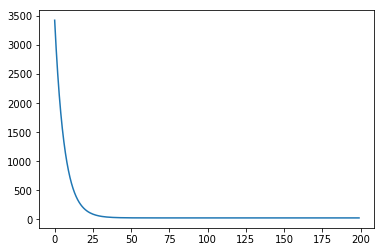

In [11]:
plt.plot(loss_array)
plt.show()

<h1>Investigating the movement across the loss function in 3d space - explaining the gradient</h1>
<div>Since in our case the loss function had only two parameters (a and b) it is possible to create a human readable plot illustrating its shape. Moreover, it is possible to visualize a trajectory that our optimization algorithm took in this loss function space. The below plot illustrates just that:</div>

In [21]:
loss_function_array[0]

0.77207005

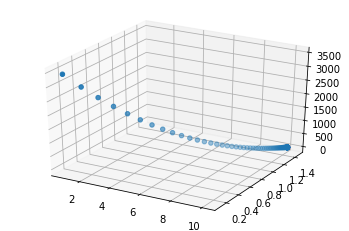

In [18]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.scatter([i[0] for i in loss_function_array],[i[1] for i in loss_function_array],[i[2] for i in loss_function_array])
plt.show()

<div>Lets now extend our visualization by plotting it against the entire loss function in this region. Since the entire dataset is used for the computation of the loss function we obtain just one plane and the trajectory that our optimizer takes is fairly smooth with almost no noise. This will not be the case when we start working with subsets of the data and start using the Stochastic Gradient Descent.</div>

In [22]:
loss_surface = []

with tf.device('/device:GPU:0'):
    # Create the placeholders for the data to be used in TensorFlow
    X = tf.placeholder(tf.float32, name="X")
    Y = tf.placeholder(tf.float32, name="Y")
    
    # Create our model variables a (indicated here as w which stands for weights) and b (referred to as bias).
    w = tf.placeholder(tf.float32, name="weights")
    b = tf.placeholder(tf.float32, name="bias")
    
    # We define out model
    Y_predicted = X * w + b
    
    # We define the loss function which is an indicator of how good or bad our model is
    loss = tf.reduce_mean(tf.squared_difference(Y_predicted, Y))

with tf.Session() as sess:
    # We initialize the necessary variables.
    sess.run(tf.global_variables_initializer())
    # And we start the training process. 
    for w_value in np.linspace(0,20,20):
        for b_value in np.linspace(-18,22,20):
            # We collect information about the loss function surface 
            loss_value = sess.run(loss, feed_dict={X: data['x'], Y:data['y'], w:w_value, b:b_value})
            loss_surface.append((w_value, b_value, loss_value))

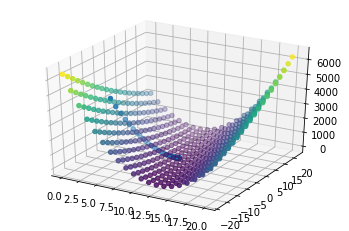

In [23]:
fig = plt.figure()
ax2 = fig.gca(projection='3d')
ax2.scatter([i[0] for i in loss_surface],[i[1] for i in loss_surface],[i[2] for i in loss_surface],
            c=[i[2] for i in loss_surface])
ax2.scatter([i[0] for i in loss_function_array],[i[1] for i in loss_function_array],[i[2] for i in loss_function_array])
plt.show()

<h1> Stochastic Gradient Descent</h1>

<div>In contrast to Gradient Descent, the Stochastic Gradient Descent does not use the entire dataset for the calculation of the shape of the cost function. Instead smaller subsets of the data are used. This has profound implications for the performance of our algorithm. Since every batch is different, even for the same set of weight those batches will provide a different gradient which introduces a level of noise as illustrated in the images below.</div>
<br/>
<div>What we can see below is an oversimplification of the Stochastic Gradient Descent algorithm. The thick green line illustrates the shape of the loss function given all the data. The thin green line the shape of the loss function given the minibatch. Since those curves are materially different the estimation of the gradient will be different at every step as well leading to a level of noise in our trajectory.</div>
<img src='https://developer.download.nvidia.com/training/images/C-MG-01-V1_task1_img_SGD1.png'>Step 1</img>
<img src='https://developer.download.nvidia.com/training/images/C-MG-01-V1_task1_img_SGD2.png'>Step 2</img>
<img src='https://developer.download.nvidia.com/training/images/C-MG-01-V1_task1_img_SGD3.png'>Step 3</img>
<div>As we will see below this noise is actually very beneficial as it generates minima with significantly different mathematical properties than Gradient Descent. The reason why this is important in the Multi GPU training problem is because by increasing the number of GPUs participating in the training process we effectively increase the batch size. By doing so we are systematically removing this beneficial noise what leads to certain algorithmic challenges which will be described in the second class of today.</div>
<br/>
<div>To demonstrate this phenomenon let's make a minor difference in our code. Rather than providing all of the data to the model in every iteration, we will provide just a single example amplifying the effect.</div>

In [25]:
# Once again we define the model
with tf.device('/device:GPU:0'):
    # Create the placeholders for the data to be used in TensorFlow
    X = tf.placeholder(tf.float32, name="X")
    Y = tf.placeholder(tf.float32, name="Y")
    
    # Create our model variables a (indicated here as w what stands for weights) and b (referred to as bias).
    w = tf.Variable(0.0, name="weights")
    b = tf.Variable(0.0, name="bias")
    
    # We define out model
    Y_predicted = X * w + b

In [26]:
# Once again we define our loss function
with tf.device('/device:GPU:0'):
    # We define the loss function which is an indicator of how good or bad our model is
    loss = tf.reduce_mean(tf.squared_difference(Y_predicted, Y))

In [27]:
# Once again we define our optimiser
with tf.device('/device:GPU:0'): 
    # We define a gradient descent optimiser
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001).minimize(loss)

In [28]:
# Create the variables used for logging
loss_array = []
loss_function_array = []

In [29]:
# Execute our training loop
number_of_epochs = 200

with tf.Session() as sess:
    # We initialize the necessary variables.
    sess.run(tf.global_variables_initializer())
    # And we start the training process. 
    for i in range(number_of_epochs):
        for x, y in data:
            # This time we provide the minimatch of 1 rather than passing the entire dataset
            sess.run(optimizer, feed_dict={X: x, Y:y})
            loss_array.append(sess.run(loss, feed_dict={X: x, Y:y}))
            w_value, b_value, loss_value = sess.run([w, b, loss], feed_dict={X: x, Y:y})
            loss_function_array.append((w_value, b_value, loss_value))
        # At the end of every 10th epoch print out the learned weights
        if i % 10 is 0:
            w_value, b_value, loss_value = sess.run([w, b, loss], feed_dict={X: x, Y:y})
            print(w_value, b_value, loss_value)
    print("Training Finished!")

10.178135 1.3820256 11.798907
10.187957 1.3361154 11.623117
10.192294 1.3072039 11.487273
10.195003 1.289148 11.402846
10.196693 1.2778764 11.350299
10.19775 1.2708385 11.317563
10.19841 1.266442 11.29713
10.198821 1.2636979 11.284388
10.199079 1.2619823 11.276419
10.199239 1.2609124 11.271449
10.199339 1.2602448 11.26835
10.199402 1.2598277 11.266429
10.19944 1.2595677 11.265201
10.199466 1.2594051 11.26447
10.19948 1.2593005 11.263958
10.19949 1.2592384 11.263677
10.199497 1.2592014 11.2635355
10.1995 1.2591745 11.263395
10.199502 1.2591615 11.263331
10.199502 1.2591554 11.263292
Training Finished!


<div>Rather than obtaining a smooth line like in the previous example we can clearly see a fair amount of noise in the data. The algorithms finds a reasonable solution regardless.</div>

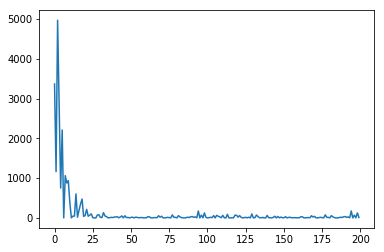

In [30]:
plt.plot(loss_array[0:200])
plt.show()

<div>Also plotting the trajectory taken by our optimizer in the loss space reveals substantial amount of noise</div>

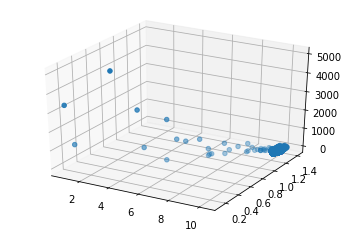

In [31]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.scatter([i[0] for i in loss_function_array],[i[1] for i in loss_function_array],[i[2] for i in loss_function_array])
plt.show()

In [34]:
loss_surface = []

with tf.device('/device:GPU:0'):
    # Create the placeholders for the data to be used in TensorFlow
    X = tf.placeholder(tf.float32, name="X")
    Y = tf.placeholder(tf.float32, name="Y")
    
    # Create our model variables a (indicated here as w what stands for weights) and b (referred to as bias).
    w = tf.placeholder(tf.float32, name="weights")
    b = tf.placeholder(tf.float32, name="bias")
    
    # We define out model
    Y_predicted = X * w + b
    
    # We define the loss function which is an indicator of how good or bad our model is
    loss = tf.reduce_mean(tf.squared_difference(Y_predicted, Y))

with tf.Session() as sess:
    # We initialize the necessary variables.
    sess.run(tf.global_variables_initializer())
    # And we start the training process. 
    for w_value in np.linspace(0,20,20):
        for b_value in np.linspace(-18,22,20):
            # We collect information about the loss function surface 
            loss_value = sess.run(loss, feed_dict={X: x, Y:y, w:w_value, b:b_value})
            loss_surface.append((w_value, b_value, loss_value))

<div>Plotting the loss surface for one of the mini batches clearly illustrates that it no longer aligns with the optimization trajectory which was generated one minibatch at a time (and for every minibatch the loss surface was indeed different).</div>

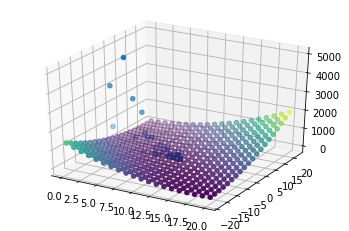

In [35]:
fig = plt.figure()
ax2 = fig.gca(projection='3d')
ax2.scatter([i[0] for i in loss_surface],[i[1] for i in loss_surface],[i[2] for i in loss_surface],
            c=[i[2] for i in loss_surface])
ax2.scatter([i[0] for i in loss_function_array],[i[1] for i in loss_function_array],[i[2] for i in loss_function_array])
plt.show()

<div> In this part of the class we have learned:
    <ul>
        <li> The basic components of the neural network training process</li>
        <li> The difference between gradient descent and stochastic gradient descent and the impact they have on the optimization process</li>
        <li> Discussed how multi GPU training affects the batch size and therefore our algorithm behavior
        </li>
    </ul>
    In the next part of this Lab we will take the code developed above and expand it to a larger neural network so that in the third part of the class we can demonstrate multi GPU implementation.
</div>

Before you move to the next part of the exercise (in the next notebook) please make sure you free any used GPU resources by restarting the IPYTHON kernel. You can do that either by selecting Kernel->Restart or running the code snipped listed below.

In [36]:
import IPython
app = IPython.Application.instance()
app.kernel.do_shutdown(True) 

{'restart': True, 'status': 'ok'}